In [ ]:
!pip install catboost

     |████████████████████████████████| 66.1MB 46kB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold
from sklearn.utils import resample
from catboost import CatBoostClassifier

# Data Analysis

In [ ]:
train = pd.read_csv("/content/drive/My Drive/JH_CrossSellPrediction/train.csv")
test = pd.read_csv("/content/drive/My Drive/JH_CrossSellPrediction/test.csv")
submission = pd.read_csv("/content/drive/My Drive/JH_CrossSellPrediction/sample_submission_iA3afxn.csv")

## Check null and basic class counts and so on

In [ ]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [ ]:
test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [ ]:
train['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [ ]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# Basic normalization, ohe and label encoding

In [ ]:
## We will label encode for variable Vehicle_Age, Vehicle Damage
## OHE for Male /Female (as it is not ordinal)
## Age, AnnualPremium,Vintage standardization (z value)

In [ ]:
def combine_df(train,test):
  train['is_train'] = 1
  test['is_train'] = 0
  return pd.concat([train,test],axis=0)

In [ ]:
combined = combine_df(train,test)

In [ ]:
combined['Vehicle_Age'].value_counts()

1-2 Year     267015
< 1 Year     219805
> 2 Years     21326
Name: Vehicle_Age, dtype: int64

In [ ]:
combined['Vehicle_Damage'].value_counts()

Yes    256248
No     251898
Name: Vehicle_Damage, dtype: int64

In [ ]:
vehicle_age = {"< 1 Year": 1,
               "1-2 Year": 2,
               "> 2 Years":3}
vehicle_damage = {"Yes":1,"No":0}

combined['Vehicle_Age'] = combined['Vehicle_Age'].map(vehicle_age)
combined['Vehicle_Damage'] = combined['Vehicle_Damage'].map(vehicle_damage)

In [ ]:
combined['Gender'].value_counts()

Male      274325
Female    233821
Name: Gender, dtype: int64

In [ ]:
combined = pd.get_dummies(combined,columns=['Gender'])

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1
4,5,29,1,41.0,1,1,0,27496.0,152.0,39,0.0,1,1,0


In [ ]:
def z_score(x, x_mean, x_std):
  return (x - x_mean) / x_std

In [ ]:
# Age_mean = combined['Age'].mean()
# Age_std = combined['Age'].std()
# combined['Age'] = combined['Age'].apply(z_score, args=(Age_mean, Age_std))

In [ ]:
# Premium_mean = combined['Annual_Premium'].mean()
# Premium_std = combined['Annual_Premium'].std()
# combined['Annual_Premium'] = combined['Annual_Premium'].apply(z_score, args=(Premium_mean, Premium_std))

In [ ]:
# Vintage_mean = combined['Vintage'].mean()
# Vintage_std = combined['Vintage'].std()
# combined['Vintage'] = combined['Vintage'].apply(z_score, args=(Vintage_mean, Vintage_std))

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1
4,5,29,1,41.0,1,1,0,27496.0,152.0,39,0.0,1,1,0


In [ ]:
combined.shape

(508146, 14)

In [ ]:
combined.drop_duplicates().shape

(508146, 14)

# Feature Engineering

In [ ]:
combined['mean_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('mean')
combined['sum_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('sum')
combined['max_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('max')
combined['min_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('mean')
combined['sum_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('sum')
combined['max_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('max')
combined['min_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('min')

In [ ]:
combined['mean_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('mean')
combined['sum_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('sum')
combined['max_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('max')
combined['min_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('mean')
combined['sum_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('sum')
combined['max_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('max')
combined['min_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('min')

In [ ]:
combined['mean_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('mean')
combined['sum_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('sum')
combined['max_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('max')
combined['min_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('mean')
combined['sum_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('sum')
combined['max_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('max')
combined['min_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('min')

In [ ]:
combined['mean_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('mean')
combined['sum_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('sum')
combined['max_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('max')
combined['min_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('mean')
combined['sum_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('sum')
combined['max_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('max')
combined['min_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('min')

In [ ]:
combined['mean_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('mean')
combined['sum_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('sum')
combined['max_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('max')
combined['min_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('mean')
combined['sum_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('sum')
combined['max_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('max')
combined['min_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('min')

In [ ]:
combined['mean_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('mean')
combined['sum_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('sum')
combined['max_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('max')
combined['min_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('mean')
combined['sum_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('sum')
combined['max_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('max')
combined['min_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('min')

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,mean_Vintage_per_vehicle_age,sum_Vintage_per_vehicle_age,max_Vintage_per_vehicle_age,min_Vintage_per_vehicle_age,mean_Age_per_vehicle_damage,sum_Age_per_vehicle_damage,max_Age_per_vehicle_damage,min_Age_per_vehicle_damage,mean_Annual_Premium_per_vehicle_damage,sum_Annual_Premium_per_vehicle_damage,max_Annual_Premium_per_vehicle_damage,min_Annual_Premium_per_vehicle_damage,mean_Vintage_per_vehicle_damage,sum_Vintage_per_vehicle_damage,max_Vintage_per_vehicle_damage,min_Vintage_per_vehicle_damage,mean_Age_per_Previously_Insured,sum_Age_per_Previously_Insured,max_Age_per_Previously_Insured,min_Age_per_Previously_Insured,mean_Annual_Premium_per_Previously_Insured,sum_Annual_Premium_per_Previously_Insured,max_Annual_Premium_per_Previously_Insured,min_Annual_Premium_per_Previously_Insured,mean_Vintage_per_Previously_Insured,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,154.740739,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,154.193603,41172005,299,10,34.613534,8719080,85,20,30390.091791,7.655203e+09,540165.0,2630.0,154.431119,38900890,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,154.740739,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637

In [ ]:
combined['Vintage'].describe()

count    508146.000000
mean        154.340123
std          83.668793
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

In [ ]:
combined['Premium_by_age'] = combined['Annual_Premium'] / combined['Age']

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,sum_Vintage_per_vehicle_age,max_Vintage_per_vehicle_age,min_Vintage_per_vehicle_age,mean_Age_per_vehicle_damage,sum_Age_per_vehicle_damage,max_Age_per_vehicle_damage,min_Age_per_vehicle_damage,mean_Annual_Premium_per_vehicle_damage,sum_Annual_Premium_per_vehicle_damage,max_Annual_Premium_per_vehicle_damage,min_Annual_Premium_per_vehicle_damage,mean_Vintage_per_vehicle_damage,sum_Vintage_per_vehicle_damage,max_Vintage_per_vehicle_damage,min_Vintage_per_vehicle_damage,mean_Age_per_Previously_Insured,sum_Age_per_Previously_Insured,max_Age_per_Previously_Insured,min_Age_per_Previously_Insured,mean_Annual_Premium_per_Previously_Insured,sum_Annual_Premium_per_Previously_Insured,max_Annual_Premium_per_Previously_Insured,min_Annual_Premium_per_Previously_Insured,mean_Vintage_per_Previously_Insured,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,41172005,299,10,34.613534,8719080,85,20,30390.091791,7.655203e+09,540165.0,2630.0,154.431119,38900890,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2630.0,154.

In [ ]:
combined['mean_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('mean')
combined['sum_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('sum')
combined['max_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('max')
combined['min_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('mean')
combined['sum_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('sum')
combined['max_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('max')
combined['min_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('min')

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,sum_Vintage_per_vehicle_damage,max_Vintage_per_vehicle_damage,min_Vintage_per_vehicle_damage,mean_Age_per_Previously_Insured,sum_Age_per_Previously_Insured,max_Age_per_Previously_Insured,min_Age_per_Previously_Insured,mean_Annual_Premium_per_Previously_Insured,sum_Annual_Premium_per_Previously_Insured,max_Annual_Premium_per_Previously_Insured,min_Annual_Premium_per_Previously_Insured,mean_Vintage_per_Previously_Insured,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,38900890,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2

In [ ]:
combined['mean_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('mean')
combined['sum_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('sum')
combined['max_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('max')
combined['min_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('mean')
combined['sum_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('sum')
combined['max_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('max')
combined['min_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('min')

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,3

In [ ]:
combined['Driving_License_per_Region_code'] = combined.groupby(['Region_Code'])['Driving_License'].transform("sum")

In [ ]:
combined['PreviouslyInsured_per_Region_code'] = combined.groupby(['Region_Code'])['Previously_Insured'].transform("sum")

In [ ]:
combined['VehicleDamage_per_Region_code'] = combined.groupby(['Region_Code'])['Vehicle_Damage'].transform("sum")

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code
0,1,0.334937,1,28.0,0,3,1,0.577348,26.0,0.748904,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767
1,2,2.399430,1,3.0,0,2,0,0.173886,26.0,0.342540,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10,12328,6000,5937
2,3,0.528483,1,28.0,0,3,1,0.451376,26.0,-1.521955,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767
3,4,-1.148917,

## Normalization

In [ ]:
Age_mean = combined['Age'].mean()
Age_std = combined['Age'].std()
combined['Age'] = combined['Age'].apply(z_score, args=(Age_mean, Age_std))

In [ ]:
Premium_mean = combined['Annual_Premium'].mean()
Premium_std = combined['Annual_Premium'].std()
combined['Annual_Premium'] = combined['Annual_Premium'].apply(z_score, args=(Premium_mean, Premium_std))

In [ ]:
Vintage_mean = combined['Vintage'].mean()
Vintage_std = combined['Vintage'].std()
combined['Vintage'] = combined['Vintage'].apply(z_score, args=(Vintage_mean, Vintage_std))

# Model

## Helpful method for accuracy detection

In [ ]:
def print_score(m):
  all_metrics = [m.score(X_train,y_train),m.score(X_test,y_test), m.score(X_valid, y_valid)]
  if hasattr(m,"oob_score"):
    all_metrics.append(m.oob_score)
  return all_metrics 


def evaluate_model(y_true, y_pred):
    print('confusion matrix')
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm.T)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)
    print('classification report')
    print(classification_report(y_true,y_pred))
    print('accuracy score')
    print(accuracy_score(y_true, y_pred))

## Splitting into train and test

In [ ]:
combined.columns

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage',
       ...
       'sum_Annual_Premium_per_insured_damage_license',
       'max_Annual_Premium_per_insured_damage_license',
       'min_Annual_Premium_per_insured_damage_license',
       'mean_Vintage_per_insured_damage_license',
       'sum_Vintage_per_insured_damage_license',
       'max_Vintage_per_insured_damage_license',
       'min_Vintage_per_insured_damage_license',
       'Driving_License_per_Region_code', 'PreviouslyInsured_per_Region_code',
       'VehicleDamage_per_Region_code'],
      dtype='object', length=114)

In [ ]:
train = combined[combined['is_train'] == 1]
test = combined[combined['is_train'] == 0]

In [ ]:
train.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code
0,1,0.334937,1,28.0,0,3,1,0.577348,26.0,0.748904,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767
1,2,2.399430,1,3.0,0,2,0,0.173886,26.0,0.342540,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10,12328,6000,5937
2,3,0.528483,1,28.0,0,3,1,0.451376,26.0,-1.521955,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767
3,4,-1.148917,

In [ ]:
train.columns

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage',
       ...
       'sum_Annual_Premium_per_insured_damage_license',
       'max_Annual_Premium_per_insured_damage_license',
       'min_Annual_Premium_per_insured_damage_license',
       'mean_Vintage_per_insured_damage_license',
       'sum_Vintage_per_insured_damage_license',
       'max_Vintage_per_insured_damage_license',
       'min_Vintage_per_insured_damage_license',
       'Driving_License_per_Region_code', 'PreviouslyInsured_per_Region_code',
       'VehicleDamage_per_Region_code'],
      dtype='object', length=114)

## Upsample

In [ ]:
combined['Response'].value_counts()

0.0    334399
1.0     46710
Name: Response, dtype: int64

In [ ]:
df_majority = combined[combined.Response==0.0]
df_minority = combined[combined.Response==1.0]
 
# downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=46710,    # to match minority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_minority, df_majority_downsampled])
 

In [ ]:
df_downsampled['Response'].value_counts()

0.0    46710
1.0    46710
Name: Response, dtype: int64

In [ ]:
train = df_downsampled.copy()

## Split into X and y

In [ ]:
X = train.drop(['id','Response','is_train'],axis=1)
y = train['Response']

X_test = test.drop(['id','Response','is_train'],axis=1)
y_test = test['Response']

In [ ]:
# X = train[['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
#        'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
#        'Policy_Sales_Channel', 'Vintage',
#       'Gender_Female', 'Gender_Male']]
# y = train['Response']

# X_test = test[['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
#        'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
#        'Policy_Sales_Channel', 'Vintage',
#       'Gender_Female', 'Gender_Male']]
# y_test = test['Response']
 

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=88)

## LightGBM

In [ ]:
estimators = [150,200,300]
for estimator in estimators:
  model = lgb.LGBMClassifier(n_estimators=estimator, class_weight="balanced")
  model.fit(X_train,y_train)

  print("Estimators ===>{}".format(estimator))
  y_pred = model.predict(X_valid)
  evaluate_model(y_valid,y_pred)
  print("===============================================")

Estimators ===>150
confusion matrix
True          0     1
Predicted            
0          6140   726
1          3137  8681
classification report
              precision    recall  f1-score   support

         0.0       0.89      0.66      0.76      9277
         1.0       0.73      0.92      0.82      9407

    accuracy                           0.79     18684
   macro avg       0.81      0.79      0.79     18684
weighted avg       0.81      0.79      0.79     18684

accuracy score
0.7932455576964248
Estimators ===>200
confusion matrix
True          0     1
Predicted            
0          6152   738
1          3125  8669
classification report
              precision    recall  f1-score   support

         0.0       0.89      0.66      0.76      9277
         1.0       0.74      0.92      0.82      9407

    accuracy                           0.79     18684
   macro avg       0.81      0.79      0.79     18684
weighted avg       0.81      0.79      0.79     18684

accuracy score
0.793

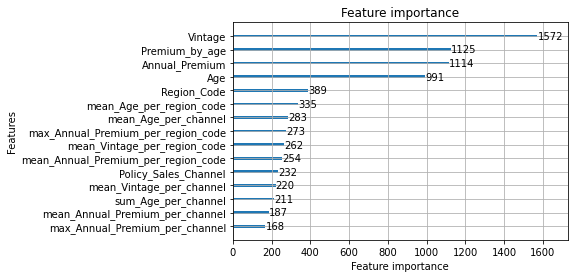

In [ ]:
lgb.plot_importance(model,max_num_features = 15)

In [ ]:
model = lgb.LGBMClassifier(n_estimators=200, class_weight='balanced')
model.fit(X,y)
y_pred_test = model.predict(X_test)

In [ ]:
submission['Response_pred'] = y_pred_test

In [ ]:
submission.shape

(127037, 3)

In [ ]:
submission.drop("Response",axis=1,inplace=True)

In [ ]:
submission.head()

,id,Response_pred
0,381110,0.0
1,381111,1.0
2,381112,1.0
3,381113,0.0
4,381114,0.0


In [ ]:
submission.columns = ['id','Response']

In [ ]:
submission.to_csv("lgb_downsampled_v2.csv",index=False)

## Stratified kfold catboost

In [ ]:
np.zeros((len(test), 10))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
train['Response'].value_counts()

0.0    334399
1.0     46710
Name: Response, dtype: int64

In [ ]:
334399/46710

7.15904517233997

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [ ]:
err = [] 
y_pred_tot_lgm = np.zeros((len(test), 2))


fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    m = lgb.LGBMClassifier(n_estimators=200,
                       random_state=2020,
                       eval_metric='Accuracy',
                       learning_rate=0.08,
                       depth=8,
                       bagging_temperature=0.3,
                       class_weights = 'balanced'
                       #num_leaves=64
                       
                     )
    x_train,y_train = smote.fit_resample(x_train,y_train)
    m.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds=100,verbose=200)
    pred_y = m.predict(x_val)
    print(i, " err_lgm: ", accuracy_score(y_val,pred_y))
    err.append(accuracy_score(y_val,pred_y))
    y_pred_tot_lgm+= m.predict_proba(X_test)
    i = i + 1
# y_pred_tot_lgm=y_pred_tot_lgm/2
# print(sum(err)/10)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.305271
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.305271
1  err_lgm:  0.8220198892708142


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.310612
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.310612
2  err_lgm:  0.8161423211146388


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.305964
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.305964
3  err_lgm:  0.8199207577864659


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.312523
Did not meet early stopping. Best iteration is:
[198]	valid_0's binary_logloss: 0.312462
4  err_lgm:  0.8148041247933667


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.311213
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.311213
5  err_lgm:  0.8148566030804755


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.310864
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.310864
6  err_lgm:  0.8185038440345307


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.317585
Did not meet early stopping. Best iteration is:
[176]	valid_0's binary_logloss: 0.311525
7  err_lgm:  0.8114717535619638


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.309265
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.309265
8  err_lgm:  0.8193172574847157


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.307456
Did not meet early stopping. Best iteration is:
[199]	valid_0's binary_logloss: 0.307451
9  err_lgm:  0.8226758678596731


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.30833
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.30833
10  err_lgm:  0.8159013382314353


In [ ]:
y_pred_tot_lgm

array([[9.98675044e+00, 1.32495557e-02],
       [5.42737671e+00, 4.57262329e+00],
       [4.14985083e+00, 5.85014917e+00],
       ...,
       [9.99471285e+00, 5.28715055e-03],
       [9.99359122e+00, 6.40878109e-03],
       [9.97910078e+00, 2.08992194e-02]])

In [ ]:
y_pred_tot_lgm=y_pred_tot_lgm/2
print(sum(err)/10)

0.8175613757218081


In [ ]:
y_pred_tot_lgm

array([[4.99337522e+00, 6.62477787e-03],
       [2.71368836e+00, 2.28631164e+00],
       [2.07492542e+00, 2.92507458e+00],
       ...,
       [4.99735642e+00, 2.64357528e-03],
       [4.99679561e+00, 3.20439054e-03],
       [4.98955039e+00, 1.04496097e-02]])

In [ ]:
submission['Response_pred'] = [np.argmax(x) for x in y_pred_tot_lgm]

In [ ]:
submission.drop("Response",axis=1,inplace=True)

In [ ]:
submission.head()

,id,Response_pred
0,381110,0
1,381111,0
2,381112,1
3,381113,0
4,381114,0


In [ ]:
submission.columns = ['id','Response']

In [ ]:
submission.to_csv("lgb.csv",index=False)

In [ ]:
submission['Response'].value_counts()

0    103161
1     23876
Name: Response, dtype: int64